In [26]:
import pandas as pd
import openpyxl

In [27]:
noc_roma = pd.read_csv("NOC_ROMA_202403110800-202403111600_clusters_la.CSV")

In [28]:
noc_roma_grouped = noc_roma.groupby("cluster_id")
numero_cluster = noc_roma["cluster_id"].nunique()

cluster_corretti = []
cluster_totalmente_errati = []
cluster_parzialmente_corretti = []

for cluster_id, gruppo in noc_roma.groupby("cluster_id"):
    if gruppo["NOTE SPV"].str.contains("CORRELAZIONE OK").all():
        cluster_corretti.append(cluster_id)
    elif gruppo["NOTE SPV"].str.contains("CORRELAZIONE ERRATA").all():
        cluster_totalmente_errati.append(cluster_id)
    else:
        cluster_parzialmente_corretti.append(cluster_id)

print("Numero Cluster:", numero_cluster)
print(f"Numero di cluster corretti: {len(cluster_corretti)}")
print(f"Numero di cluster totalmente errati: {len(cluster_totalmente_errati)}")
print(f"Numero di cluster parzialmente corretti: {len(cluster_parzialmente_corretti)}")


Numero Cluster: 35
Numero di cluster corretti: 13
Numero di cluster totalmente errati: 12
Numero di cluster parzialmente corretti: 10


In [29]:
import numpy as np
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

# Assicurati che "first_occurrence" sia in formato datetime
noc_roma["first_occurrence"] = pd.to_datetime(noc_roma["first_occurrence"])

outlier_labels = []
df_list = []

for cluster_id, group in noc_roma.groupby("cluster_id"):
    # Convertire i tempi in numeri
    X = group[["first_occurrence"]].apply(lambda x: x.astype(np.int64) // 10**9).values.reshape(-1, 1)
    
    # Applicazione del Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=10, contamination="auto")
    labels = lof.fit_predict(X)
    outlier_labels.extend(labels)
    
    # Creazione di un DataFrame temporaneo con i risultati
    temp_df = pd.DataFrame({
        "cluster_id": cluster_id,
        "OUTLIER_LABEL": labels,
    })
    
    df_list.append(temp_df)

final_df = pd.concat(df_list, ignore_index=True)
filtered_noc_roma = noc_roma[["NOTE SPV"]]

# Merge dei risultati con il DataFrame originale
merge_df = pd.merge(final_df, filtered_noc_roma, left_index=True, right_index=True, how="left")
merge_df.to_excel("output.xlsx")

# Mostra i risultati
print(merge_df)


     cluster_id  OUTLIER_LABEL                              NOTE SPV
0         23801             -1         CORRELAZIONE OK CLUSTER 23801
1         23801              1         CORRELAZIONE OK CLUSTER 23801
2         23801             -1         CORRELAZIONE OK CLUSTER 23801
3         23801              1         CORRELAZIONE OK CLUSTER 23801
4         23801              1         CORRELAZIONE OK CLUSTER 23801
..          ...            ...                                   ...
313       28624              1  CORRELAZIONE ERRATA SU CLUSTER 28624
314       28624              1  CORRELAZIONE ERRATA SU CLUSTER 28624
315       28624              1  CORRELAZIONE ERRATA SU CLUSTER 28624
316       28624              1  CORRELAZIONE ERRATA SU CLUSTER 28624
317       28624              1  CORRELAZIONE ERRATA SU CLUSTER 28624

[318 rows x 3 columns]


c:\VirtualEnvironment\envs\TIM_thesis\Lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (10) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\VirtualEnvironment\envs\TIM_thesis\Lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (10) is greater than the total number of samples (3). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\VirtualEnvironment\envs\TIM_thesis\Lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (10) is greater than the total number of samples (4). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\VirtualEnvironment\envs\TIM_thesis\Lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (10) is greater than the total number of samples (4). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\VirtualEnvironment\envs\TIM_t

In [30]:
merge_grouped = merge_df.groupby("cluster_id")

predict_correct_clusters = 0
for cluster_id, group in merge_grouped:

    if cluster_id in cluster_corretti:
        if group["OUTLIER_LABEL"].nunique() == 1:
            predict_correct_clusters += 1

print(
    f"Numero di cluster corretti ricostruiti correttamente: {predict_correct_clusters} di {len(cluster_corretti)}"
)


predict_wrong_clusters = 0

for cluster_id, group in merge_grouped:

    if cluster_id in cluster_parzialmente_corretti:
        if cluster_id in cluster_parzialmente_corretti:
            # Filtra gli allarmi con "CORRELAZIONE OK"
            allarmi_ok = group[group["NOTE SPV"].str.contains("CORRELAZIONE OK")]
            # Filtra gli allarmi con "CORRELAZIONE ERRATA"
            allarmi_errata = group[
                group["NOTE SPV"].str.contains("CORRELAZIONE ERRATA")
            ]

            # Verifica che tutti gli allarmi OK abbiano la stessa label
            label_unica_ok = allarmi_ok["OUTLIER_LABEL"].nunique() == 1

            # Verifica che gli allarmi ERRATA abbiano una label diversa da quella degli allarmi OK
            if not allarmi_errata.empty and label_unica_ok:
                label_ok = 1
                # Verifica che tutte le label ERRATA siano diverse da quella OK
                label_diverse_errata = (
                    not allarmi_errata["OUTLIER_LABEL"].isin([label_ok]).any()
                )

                if label_diverse_errata:
                    predict_wrong_clusters += 1

print(
    f"Numero di cluster predetti correttamente: {predict_wrong_clusters} di {len(cluster_parzialmente_corretti)}"
)

merge_df.to_excel("merge_df.xlsx", index=False)

Numero di cluster corretti ricostruiti correttamente: 13 di 13
Numero di cluster predetti correttamente: 0 di 10


61

Valori di n_neighbors :   0%|          | 0/61 [00:00<?, ?it/s]

Valori di n_neighbors : 100%|██████████| 61/61 [00:04<00:00, 12.61it/s]


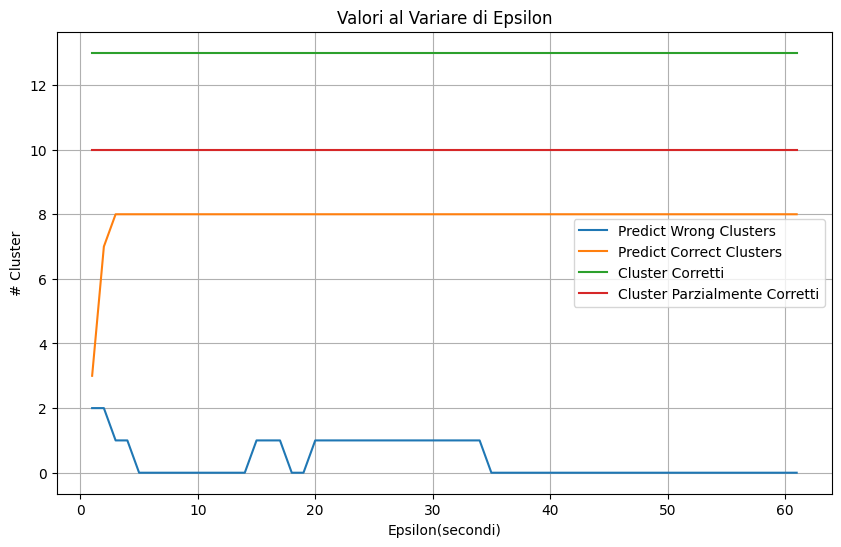

In [42]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Numero massimo di allarmi in un cluster
global_max_alarms = noc_roma.groupby("cluster_id").size().max()


n_neighbors_range = np.arange(1, global_max_alarms+1, 1)


results = []
predict_correct_clusters_values = []
predict_wrong_clusters_values = []
cluster_corretti_values = []
cluster_parzialmente_corretti_values = []

for n in tqdm(n_neighbors_range, desc="Valori di n_neighbors "):
    OUTLIER_LABELs = []
    df_list = []

    for cluster_id, group in noc_roma.groupby("cluster_id"):
        # Convertire i tempi in numeri
        X = (
            group[["first_occurrence"]]
            .apply(lambda x: x.astype(np.int64) // 10**9)
            .values.reshape(-1, 1)
        )
        if n > len(X):
            n = len(X)

        # Applicazione del Local Outlier Factor
        lof = LocalOutlierFactor(n_neighbors=n, contamination="auto")
        labels = lof.fit_predict(X)
        outlier_labels.extend(labels)

        # Creazione di un DataFrame temporaneo con i risultati
        temp_df = pd.DataFrame(
            {
                "cluster_id": cluster_id,
                "OUTLIER_LABEL": labels,
            }
        )

        df_list.append(temp_df)

    final_df = pd.concat(df_list, ignore_index=True)
    filtered_noc_roma = noc_roma[["NOTE SPV"]]

    merge_df = pd.merge(
        final_df, filtered_noc_roma, left_index=True, right_index=True, how="left"
    )

    merge_grouped = merge_df.groupby("cluster_id")

    predict_correct_clusters = 0
    for cluster_id, group in merge_grouped:

        if cluster_id in cluster_corretti:
            if group["OUTLIER_LABEL"].nunique() == 1:
                predict_correct_clusters += 1

    predict_correct_clusters_values.append(predict_correct_clusters)
    cluster_corretti_values.append(len(cluster_corretti))

    predict_wrong_clusters = 0

    for cluster_id, group in merge_grouped:

        if cluster_id in cluster_parzialmente_corretti:
            if cluster_id in cluster_parzialmente_corretti:
                # Filtra gli allarmi con "CORRELAZIONE OK"
                allarmi_ok = group[group["NOTE SPV"].str.contains("CORRELAZIONE OK")]
                # Filtra gli allarmi con "CORRELAZIONE ERRATA"
                allarmi_errata = group[
                    group["NOTE SPV"].str.contains("CORRELAZIONE ERRATA")
                ]

                # Verifica che tutti gli allarmi OK abbiano la stessa label
                label_unica_ok = allarmi_ok["OUTLIER_LABEL"].nunique() == 1

                # Verifica che gli allarmi ERRATA abbiano una label diversa da quella degli allarmi OK
                if not allarmi_errata.empty and label_unica_ok:
                    label_ok = allarmi_ok["OUTLIER_LABEL"].iloc[0]
                    # Verifica che tutte le label ERRATA siano diverse da quella OK
                    label_diverse_errata = (
                        not allarmi_errata["OUTLIER_LABEL"].isin([label_ok]).any()
                    )

                    if label_diverse_errata:
                        predict_wrong_clusters += 1
    predict_wrong_clusters_values.append(predict_wrong_clusters)
    cluster_parzialmente_corretti_values.append(len(cluster_parzialmente_corretti))


plt.figure(figsize=(10, 6))


plt.plot(
    n_neighbors_range, predict_wrong_clusters_values, label="Predict Wrong Clusters"
)
plt.plot(
    n_neighbors_range, predict_correct_clusters_values, label="Predict Correct Clusters"
)
plt.plot(n_neighbors_range, cluster_corretti_values, label="Cluster Corretti")
plt.plot(
    n_neighbors_range,
    cluster_parzialmente_corretti_values,
    label="Cluster Parzialmente Corretti",
)


plt.xlabel("Epsilon(secondi)")
plt.ylabel("# Cluster")
plt.title("Valori al Variare di Epsilon")
plt.legend()
plt.grid(True)


plt.show()